#### Demo of a simple text query based audio retrieval
We have a bunch of labeled audio files. We augment the audio features with embeddings of text labels associated with the audio. Can we then use this simple "multi-modal representation" for retrieving sounds that are "similar" to a text query?

In [1]:
import glob
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
import librosa
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import os
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

Using Theano backend.


We use pretrained word embeddings from Google News.

In [15]:
word_embeddings_file = '../data/GoogleNews-vectors-negative300.bin'
w2v_model = KeyedVectors.load_word2vec_format(word_embeddings_file, binary=True)

In [3]:
data_dir = '../data/esc-50'
sample_dir = os.path.join(data_dir, 'sample')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [4]:
print 'Sound Sample Classes'
print '--------------------'
for d in os.listdir(sample_dir):
    print d

Sound Sample Classes
--------------------
coughing
footsteps
insects
laughing
rooster


In [5]:
samples_dict = dict()
for d in os.listdir(sample_dir):
    sample_class_dir = os.path.join(sample_dir, d)
    samples_dict[d] = [os.path.join(sample_class_dir, f) for f in os.listdir(sample_class_dir)]
for k, v in samples_dict.iteritems():
    print k, len(v)

insects 40
coughing 40
footsteps 40
laughing 40
rooster 40


Extract audio features as before. But also add word embeddings of the labels.

In [6]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    np.nan_to_num(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz


def build_feature_matrix(parent_dir, sub_dirs, classes, file_ext='*.ogg'):
    features, labels = np.empty((0, 493)), np.empty(0)
    filenames = list()
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            w2v_features = get_w2v_features(sub_dir)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz, w2v_features])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, sub_dir)
            filenames.append(fn)
    return np.array(features), filenames, labels


def get_w2v_features(label):
    return w2v_model[label]

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [7]:
sample_dir = os.path.join(data_dir, 'sample')
sub_dirs = ['laughing', 'coughing', 'insects', 'rooster', 'crying_baby', 'footsteps']
classes = {'laughing': 0, 'coughing': 1, 'insects': 2, 'rooster': 3, 'crying_baby': 4, 'footsteps': 5}

if not os.path.exists('sample_sound_features.npy'): 
    features, filenames, labels = build_feature_matrix(sample_dir, sub_dirs, classes)
else:
    features = np.load('sample_sound_features.npy')
    with open('sample_files.txt') as fp:
        filenames = [fn.strip() for fn in fp.readlines()]
    with open('sample_labels.txt') as fp:
        labels = [lb.strip() for lb in fp.readlines()]

In [8]:
print features.shape
print len(filenames)
print len(labels)

(196, 493)
196
196


In [9]:
outfile = 'sample_sound_features.npy'
np.save(outfile, features)
with open('sample_files.txt', 'w') as fp:
    fp.write('\n'.join(filenames))
with open('sample_labels.txt', 'w') as fp:
    fp.write('\n'.join(labels))

#### PCA after adding word embeddings

There is an increase in the explained variance. The plot also shows how the variances have different ranges for different classes.

In [10]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd

features_df = pd.DataFrame(features)
data_scaled = pd.DataFrame(preprocessing.scale(features_df), columns=features_df.columns)
pca = PCA(n_components=5)
pca_results = pca.fit_transform(data_scaled)

print 'Shape of the transformed feature vector:', pca_results.shape
print 'Original training sample:', list(features_df.loc[0].values)
print 'Training sample after PCA:', list(pca_results[0])
print '\n'
# Percentage of variance explained for each components
print 'Explained variance ratio (first five components)'
print '------------------------------------------------'
for idx, r in enumerate(pca.explained_variance_ratio_):
    print 'Principal Component', idx, ':', r 

Shape of the transformed feature vector: (196, 5)
Original training sample: [-211.95342873967343, 126.77311337329317, -34.790516564858109, -10.512615152990707, -36.476548766848765, -15.265458386539253, -25.452147024852891, -5.373759791325627, -17.113109621494466, 9.623134344549225, -10.928963826555067, -10.522028894620606, -8.9315416259630567, -4.2521794394544665, -10.441037332644855, -7.5970087415701366, -8.8785380383648729, -1.1939344747472949, -7.0908558885145743, 0.76262883957394723, -6.841079475167918, -6.7085224890121546, -4.9157763803929528, -2.7260106406212623, -6.4026770846192411, -2.3801003698167018, -6.0828079226609626, -1.005822607342773, -4.4659888523414537, -1.1620847727575108, -4.0551530678673311, -0.10143759270967795, -5.5333870628773516, -1.0524975933573175, -3.2479466396041592, -1.5511760810055846, -3.3662660397266997, -2.0985671973177058, -3.8624834878166756, -0.23053952005125813, 0.51834445566621268, 0.50731462792430559, 0.54732341782571448, 0.54456663467689226, 0.5

/Users/sanket/anaconda/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/sanket/anaconda/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/sanket/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


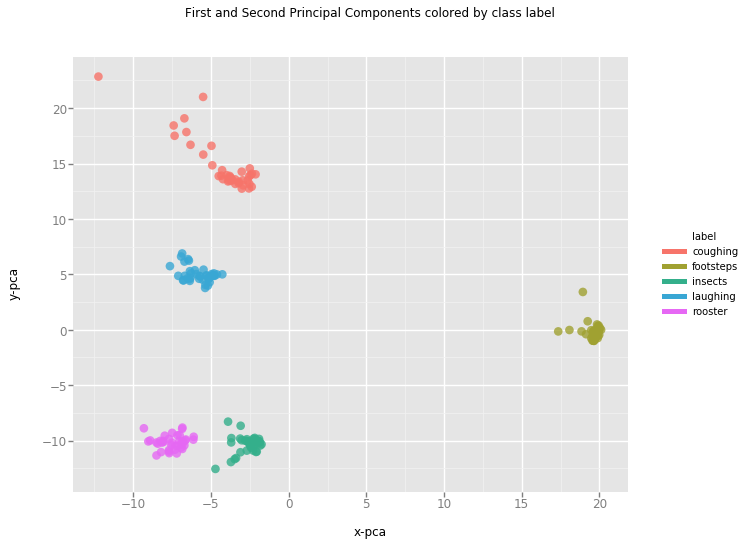

<ggplot: (296064793)>

In [11]:
from ggplot import *

df_pca = features_df.copy()
df_pca['x-pca'] = pca_results[:,0]
df_pca['y-pca'] = pca_results[:,1]
df_pca['label'] = labels
chart = ggplot( df_pca, aes(x='x-pca', y='y-pca', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by class label")
chart

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import IPython.display

In [13]:
queries = ['laugh', 'chuckle', 'joke', 'walking', 'run', 
           'jogging', 'cough', 'throat', 'mosquito', 'wasp',
           'bees', 'parrot', 'cockarel', 'crowing']

In [31]:
query = 'laugh'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: laughing


In [17]:
query = 'chuckling'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True)

Matching class: laughing


In [18]:
query = 'joke'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: laughing


In [32]:
query = 'walking'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: footsteps


In [20]:
query = 'run'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: footsteps


In [21]:
query = 'jogging'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: footsteps


In [22]:
query = 'cough'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: coughing


In [33]:
query = 'throat'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: coughing


In [24]:
query = 'mosquito'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: insects


In [25]:
query = 'wasp'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: insects


In [34]:
query = 'bees'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: insects


In [27]:
query = 'parrot'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: insects


In [28]:
query = 'cock'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: rooster


In [29]:
query = 'buzzing'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: insects


In [30]:
query = 'wheezing'
query_features = np.append(np.zeros(193), get_w2v_features(query))
idx = np.argmax(cosine_similarity(features, query_features.reshape(1, -1), dense_output=True))
result = filenames[idx]
print 'Matching class:', labels[idx]
IPython.display.Audio(result, embed=True, autoplay=True)

Matching class: coughing
